In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install gwcca

In [6]:
import numpy as np
from gwcca import joint_optimize_k_q_early, gwcca, plot_gwcca_result, plot_loading_maps, gwcca_local_permutation_test
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings("ignore", message=".*The 'type' attribute is deprecated.*")

In [4]:
data = gpd.read_file("/content/drive/My Drive/GCCA/us1.geojson")
data = data.to_crs("+proj=lcc +lat_1=33 +lat_2=45 +lat_0=39 +lon_0=-96 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")

X_columns = ['arth', 'asthma','cancer', 'deprss', 'stroke', 'diabet']
X_names = ['Arthritis', 'Asthma', 'Cancer', 'Depression', 'Stroke', 'Diabetes']

Y_columns = ['age_65', 'white', 'binge', 'impoverishment', 'black', 'hispanic']
Y_names = ['Age 65', 'White', 'Binge', 'Poverty', 'Black', 'Hispanic']

# Standardize the variables to have mean = 0 and standard deviation = 1
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X = scaler_X.fit_transform(data[X_columns].to_numpy())
Y = scaler_Y.fit_transform(data[Y_columns].to_numpy())

coords = np.vstack([data.geometry.centroid.x, data.geometry.centroid.y]).T


p, qY = X.shape[1], Y.shape[1]

r = min(p, qY)

K_grid = range(30, 301, 2)
q_grid = range(1, r)

best_K, best_q, best_gof, summary = joint_optimize_k_q_early(
    X, Y, coords,
    K_grid=K_grid,
    q_grid=q_grid,
    rel_tol=0.01, patience=2,
    slack=0.02,
    thr=None,
    min_support=None,
    use_stability=False
)

In [7]:
rho, a, b = gwcca(X, Y, coords, k_neighbors=best_K, q=best_q)

pvals = gwcca_local_permutation_test(
    X, Y, coords,
    k_neighbors=best_K,
    q=best_q,
    rho_obs=rho,
    n_perm=499
)


<Axes: title={'center': 'GWCCA rho (variate 1, p < 0.05) (Variate 1)'}, xlabel='Longitude', ylabel='Latitude'>

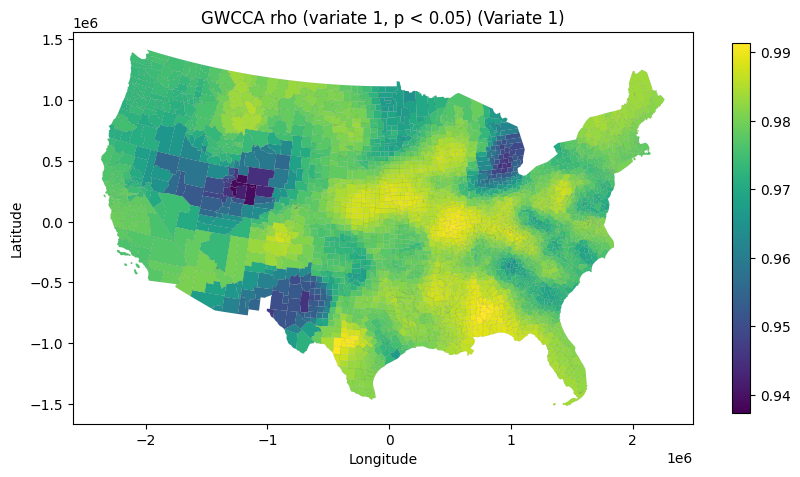

In [8]:
sig_mask = pvals[:, 0] < 0.05
rho_sig = rho[:, 0].copy()
rho_sig[~sig_mask] = np.nan

fig, ax = plt.subplots(figsize=(10,6))
plot_gwcca_result(
    data,
    rho_sig.reshape(-1,1),
    title="GWCCA rho (variate 1, p < 0.05)",
    component_idx=1,
    ax=ax
)
# plt.savefig("rho1_sig.png", dpi=600, bbox_inches="tight")


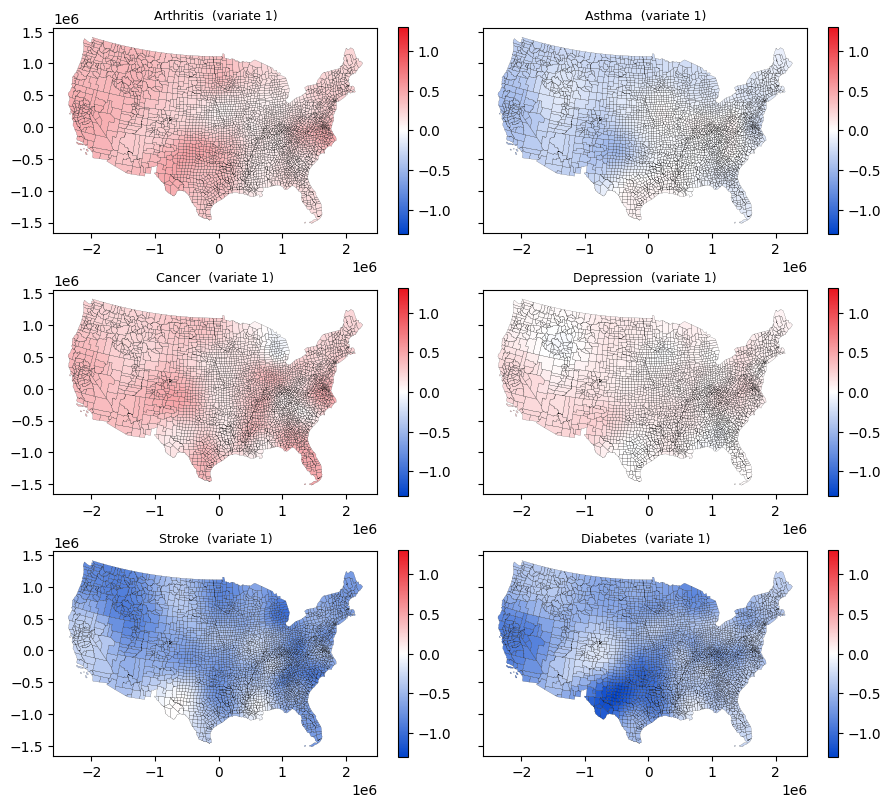

In [11]:
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_diverging", ["#0042ca", "white", "#e9141e"], N=256
)

sig_mask = pvals[:, 0] < 0.05
a_sig = a.copy()
a_sig[~sig_mask, :, :] = np.nan

plot_loading_maps(
    data, a_sig, X_names,
    component_idx=1,
    nrows=3, ncols=2, figsize=(9,8),
    cmap=cmap, diverging=True
)


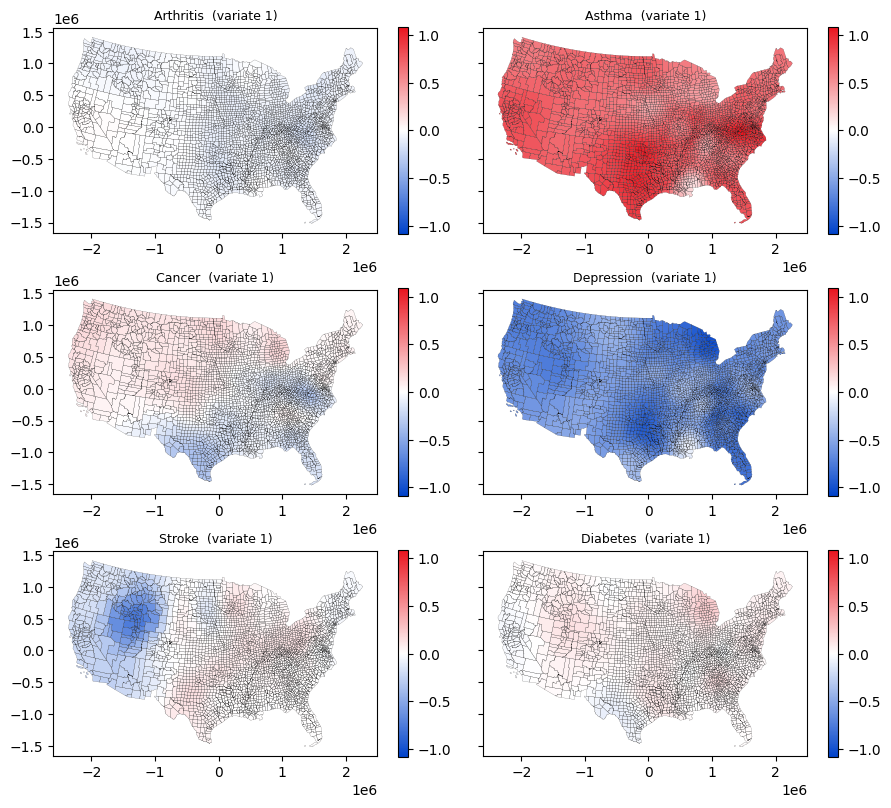

In [12]:
sig_mask = pvals[:, 0] < 0.05
b_sig = b.copy()
b_sig[~sig_mask, :, :] = np.nan

plot_loading_maps(
    data, b_sig, X_names,
    component_idx=1,
    nrows=3, ncols=2, figsize=(9,8),
    cmap=cmap, diverging=True
)